### Import libraries

In [72]:
using CSV
using DataFrames
using Turing
using Plots
using StatsBase
using StatsFuns: logistic
using MLBase
using KernelDensity
using Statistics

### Read data

In [2]:
df = CSV.read("WVS.csv")
deletecols!(df, :Column1)
y = convert(Array, df[:y])
X = convert(Matrix, df[setdiff(names(df), [:y])]);
println(typeof(X))
println(typeof(y))
println(countmap(y))

┌ Warning: `deletecols!(df::DataFrame, inds)` is deprecated, use `select!(df, Not(inds))` instead.
│   caller = top-level scope at In[2]:2
└ @ Core In[2]:2
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[2]:3
└ @ Core In[2]:3
┌ Warning: `getindex(df::DataFrame, col_inds::Union{AbstractVector, Regex, Not})` is deprecated, use `df[:, col_inds]` instead.
│   caller = top-level scope at In[2]:4
└ @ Core In[2]:4


Array{Float64,2}
Array{Int64,1}
Dict(2=>1862,3=>811,1=>2708)


### Define Ordered Logistic distribution

In [3]:
struct OrderedLogistic{T1, T2} <: DiscreteUnivariateDistribution
   η::T1
   cutpoints::Vector{T2}
end

function Distributions.logpdf(d::OrderedLogistic, k::Int)
   
    K = length(d.cutpoints)+1

    c =  d.cutpoints
    
    if k==1
        logp= log(logistic(c[k]-d.η))
    elseif k<K
        logp= log(logistic(c[k]-d.η) - logistic(c[k-1]-d.η))
    else
        logp= log(1-logistic(c[k-1]-d.η))
    end
    
    return(logp)
end

### Model specification

In [4]:
### Turing model
@model m(X, y) = begin

    D = size(X, 2)

    # priors
    sigma ~ TruncatedNormal(0,1,0,Inf)
    
    c1 ~ Normal(0, 20)
    log_diff_c ~ Normal(0, 2)
    c2 = c1 + exp(log_diff_c)
    c = [c1, c2]
    
    beta ~ MvNormal(zeros(D), sigma * ones(D))

    lp = X * beta

    # likelihood
    for i = 1:length(y)
        y[i] ~ OrderedLogistic(lp[i], c)
    end
end

m (generic function with 3 methods)

### Sampling

In [5]:
steps = 2000
chain = sample(m(X, y), NUTS(steps, 0.65));

┌ Info: Found initial step size
│   init_ϵ = 0.025
└ @ Turing.Inference /Users/kcft114/.julia/packages/Turing/m05p3/src/inference/hmc.jl:365
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /Users/kcft114/.julia/packages/AdvancedHMC/YWXfk/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /Users/kcft114/.julia/packages/AdvancedHMC/YWXfk/src/hamiltonian.jl:36
┌ Info: Finished 1000 adapation steps
│   adaptor = StanHMCAdaptor(n_adapts=1000, pc=DiagPreconditioner, ssa=NesterovDualAveraging(γ=0.05, t_0=10.0, κ=0.75, δ=0.65, state.ϵ=0.08357622551949831), init_buffer=75, term_buffer=50)
│   τ.integrator = Leapfrog(ϵ=0.0836)
│   h.metric = DiagEuclideanMetric([0.0696433, 0.0849622, 0.00 ...])
└ @ AdvancedHMC /User

### Parameter estimates

In [6]:
show(chain)

Object of type Chains, with data of type 1000×21×1 Array{Union{Missing, Float64},3}

Log evidence      = 0.0
Iterations        = 1:1000
Thinning interval = 1
Chains            = 1
Samples per chain = 1000
internals         = eval_num, lp, acceptance_rate, hamiltonian_energy, is_accept, log_density, n_steps, numerical_error, step_size, tree_depth
parameters        = beta[3], c1, log_diff_c, sigma, beta[4], beta[6], beta[5], beta[1], beta[2], beta[7], beta[8]

2-element Array{ChainDataFrame,1}

Summary Statistics

│ Row │ parameters │ mean       │ std       │ naive_se    │ mcse       │ ess     │ r_hat    │
│     │ Symbol     │ Float64    │ Float64   │ Float64     │ Float64    │ Any     │ Any      │
├─────┼────────────┼────────────┼───────────┼─────────────┼────────────┼─────────┼──────────┤
│ 1   │ beta[1]    │ -0.0268465 │ 0.303916  │ 0.00961065  │ 0.0230467  │ 247.135 │ 1.01131  │
│ 2   │ beta[2]    │ 0.138711   │ 0.302723  │ 0.00957294  │ 0.0231229  │ 232.966 │ 1.01221  │
│ 3   │ beta

In [7]:
e_log_diff_c = exp.(chain[:log_diff_c].value.data)[:,1,1]
c1_est = chain[:c1].value.data[:,1,1]
c2_est = c1_est + e_log_diff_c;
println(mean(c1_est))
println(mean(c2_est))

0.19142069387105856
1.9939986009677915


In [225]:
# bonus: plots of posterior distributions
#histogram(c1_est , bar_width=0.04, legend=false, title="Posterior distributions in Julia / Turing", yaxis=nothing)
#histogram!(c2_est )
#savefig("posterior_plot.png" )

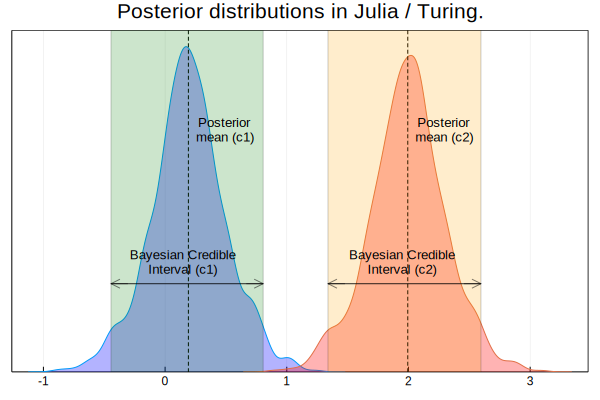

In [235]:
rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])

# =======  p1 =======================
c1_est_kde = convert(Array{Float64,1} ,c1_est)
c2_est_kde = convert(Array{Float64,1} ,c2_est)
k1 = kde(c1_est_kde)
k2 = kde(c2_est_kde)
c1_mean = mean(c1_est_kde)
c2_mean = mean(c2_est_kde)
c1_q025, c1_q975 = quantile!(c1_est_kde, [0.025, 0.975])
c2_q025, c2_q975 = quantile!(c2_est_kde, [0.025, 0.975])

p1 = plot(k1.x, k1.density, fill = (0, 0.3, :blue), label="posterior distribution, c1", 
          yticks = false, 
          legend = false,
          ylim=(0, 1.05 * maximum(vcat(k1.density, k2.density))),
          framestyle = :box,
          title="Posterior distributions in Julia / Turing.")

plot!(k2.x, k2.density, fill = (0, 0.3, :red), label="posterior distribution, c2")
vline!([c1_mean, c2_mean], color = :black, linestyle = :dash, label="posterior means")

plot!(rectangle(c1_q975-c1_q025, 1.05 * maximum(vcat(k1.density, k2.density)), c1_q025, 0), 
      color = :green, alpha = 0.2, label="95% Credible Interval, c1")
plot!(rectangle(c2_q975-c2_q025, 1.05 * maximum(vcat(k1.density, k2.density)), c2_q025, 0), 
      color = :orange, alpha = 0.2, label="95% Credible Interval, c2")

x_BCI_1 = 0.15
y_BCI_1 = 0.5
x_BCI_2 = 1.95
y_BCI_2 = y_BCI_1
y_mean = 1.1
x_c1_segm = range(c1_q025, stop = c1_q975, length=10)
x_c2_segm = range(c2_q025, stop = c2_q975, length=10)
y_c1_segm = repeat([y_BCI_1-0.1], length(x_c1_segm))
annotate!(x_BCI_1, y_BCI_1, text("Bayesian Credible \n Interval (c1)", :balck, 9))
annotate!(x_BCI_2, y_BCI_2, text("Bayesian Credible \n Interval (c2)", :balck, 9))

annotate!(c1_mean + 0.3 , y_mean, text("Posterior \n mean (c1)", :balck, 9))
annotate!(c2_mean + 0.3, y_mean, text("Posterior \n mean (c2)", :balck, 9))

plot!(x_c1_segm, y_c1_segm, seriestype = :steppre, linestyle = :solid, arrow = :arrow, linealpha = 0.5, 
      linewidth = 1, linecolor = :black)
plot!(reverse(x_c1_segm), y_c1_segm, seriestype = :steppre, linestyle = :solid, arrow = :arrow, linealpha = 0.5, 
      linewidth = 1, linecolor = :black)
plot!(x_c2_segm, y_c1_segm, seriestype = :steppre, linestyle = :solid, arrow = :arrow, linealpha = 0.5, 
      linewidth = 1, linecolor = :black)
plot!(reverse(x_c2_segm), y_c1_segm, seriestype = :steppre, linestyle = :solid, arrow = :arrow, linealpha = 0.5, 
      linewidth = 1, linecolor = :black)
#savefig("posterior_plot.png" )

## How to make predictions now? Using the generative model.

In [227]:
function Distributions.rand(d::OrderedLogistic)
    cutpoints = d.cutpoints
    η = d.η  
    
    if !issorted(cutpoints)
        error("cutpoints are not sorted")
    end

    K = length(cutpoints)+1
    c = vcat(-Inf, cutpoints, Inf)
    l = [i for i in zip(c[1:(end-1)],c[2:end])]
    ps = [logistic(η - l[i][1]) - logistic(η - l[i][2]) for i in 1:K]
    k = findall(ps.== maximum(ps))[1]
    
    if all(ps.>0)
        return(k)
    else
        return(-Inf)
    end
end

In [231]:
beta_est = chain[:beta].value.data[:,:,1]';
lp_post = X * beta_est;

y_pred_samps = zeros(size(lp_post));
y_pred = zeros(size(lp_post, 1));

for i in 1:size(y_pred_samps,1)
    for j in 1:size(y_pred_samps,2)
        
        c1 = c1_est[j,1,1]
        c2 = c2_est[j,1,1]
        c = [c1, c2]
        
        dist = OrderedLogistic(lp_post[i,j], c)
        
        y_pred_samps[i,j] = rand(dist)
    end
    
    probs = [mean(y_pred_samps[i,:] .== 1), mean(y_pred_samps[i,:] .== 2), mean(y_pred_samps[i,:] .== 3)]
    y_pred[i] = sum((probs .== maximum(probs)) .* [1, 2, 3])
end

y_pred = convert(Array{Int64,1}, y_pred);
countmap(y_pred)

Dict{Int64,Int64} with 2 entries:
  2 => 1280
  1 => 4101

### Accuracy, confusion matrix

In [232]:
mean(y .== y_pred)

0.4785355881806356

In [233]:
C = confusmat(3, y, y_pred)

3×3 Array{Int64,2}:
 2211  497  0
 1498  364  0
  392  419  0